# Automatisieren von Fehlerrechnung

$$ \sigma_{f} = \sqrt{\sum_{i=1}^m \left( \frac{\partial f}{\partial x_i}\right)^{\!2} \sigma_{x_i}^2} $$

- Gesucht: Fehler von $f(x_i)$, wenn $x_i$ Fehler haben
- Manuelle Fehlerfortpflanzung:
 1. Berechne die Ableitungen von $f$ nach allen fehlerbehafteten Größen $x_i$
 2. Ableitungen in die obere Formel einsetzen
 3. Werte und Fehler der $x_i$ einsetzen
- Probleme:
 - Kompliziert, dauert lange, man macht oft Fehler
 - Falsches Ergebnis, wenn $x_i$ korreliert sind

$$ \operatorname{cov}(\vec{f}) = \boldsymbol{J} \operatorname{cov}(\vec{x})\, \boldsymbol{J}^\top $$

$\boldsymbol{J}$ ist die Jacobimatrix von $\vec{f}$ nach $\vec{x}$.
 
## `uncertainties`

- Erlaubt es, Fehlerrechnung automatisch durchzuführen
- Datentyp: `ufloat`, repräsentiert Wert mit Fehler

In [ ]:
from uncertainties import ufloat

x = ufloat(5, 1)
y = ufloat(3, 1)

x + y

Korrelationen werden von uncertainties beachtet:

In [ ]:
x = ufloat(3, 1)
y = ufloat(3, 1)

print(x - y)
print(x - x) # error is zero!

print(x == y)

`uncertainties.unumpy` ergänzt numpy:

In [ ]:
import numpy as np
import uncertainties.unumpy as unp

x = [1, 2, 3, 4, 5]
err = [0.1, 0.3, 0.1, 0.8, 1.0]

y = unp.uarray(x, err)

unp.cos(unp.exp(y))

Zugriff auf Wert und Standardabweichung mit `n` und `s`:

In [ ]:
x = ufloat(5, 1)
print(x.n)
print(x.s)

Bei `unumpy` mit `nominal_values` und `std_devs`

In [ ]:
x = unp.uarray([1, 2, 3], [0.3, 0.3, 0.1])
print(unp.nominal_values(x))
print(unp.std_devs(x))

Kann man natürlich auch abkürzen:

In [ ]:
from uncertainties.unumpy import (nominal_values as noms,
                                  std_devs as stds)

print(noms(x))
print(stds(x))

Man muss daran denken, die Funktionen aus unumpy zu benutzen (`exp`, `cos`, etc.)

In [ ]:
np.cos(x)

# Korrelierte Werte

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 16

x = np.array([90, 60, 45, 100, 15, 23, 52, 30, 71, 88])
y = np.array([90, 71, 65, 100, 45, 60, 75, 85, 100, 80])

plt.plot(x, y, 'ro')
plt.show()


vermute eine lineare Korrelation der Messwerte. Stützen der Hypothese mit Korrelationskoeffizient:

$$r = \frac{cov(x, y)}{\sigma_x \sigma_y}, \quad -1 \leq r \leq 1$$ 

In [ ]:
x_mean = np.mean(x)
y_mean = np.mean(y)

corr_coeff = sum((x - x_mean) * (y - y_mean)) / np.sqrt(sum((x - x_mean)**2) * sum((y - y_mean)**2))
print(corr_coeff)

Korrelation zwischen Variablen mit correlated_values erzeugen: 

In [ ]:
from uncertainties import correlated_values

values = [1, 2]

cov = [[0.5, 0.25],
       [0.25, 0.2]]

x, y = correlated_values(values, cov) 

### Vorsicht bei Fits:
korrelierte Fit-Parameter führen zu nichts-sagenden Ergebnissen. Kontrolle: Korrelationsmatrix.

0.56+/-0.06
1.92+/-0.06

[[ 0.0034807  -0.00341948]
 [-0.00341948  0.00342949]]


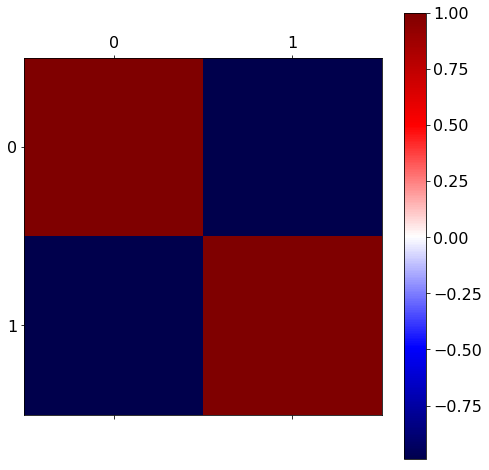

In [3]:
%matplotlib inline

from numpy.random import normal
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 16
from scipy.optimize import curve_fit
from uncertainties import correlated_values, correlation_matrix

def f1(x, a, b):
    return a * np.exp(b * x)

def f2(x, a, b, c):
    return a * np.exp(b * x + c)

x = np.linspace(0, 2, 30)
y = 0.5 * np.exp(2 * x) + normal(0, 1, 30)


params, cov = curve_fit(f1, x, y)
#params, cov = curve_fit(f2, x, y)

params = correlated_values(params, cov)

for param in params:
    print(param)
print()
print(cov)

plt.matshow(correlation_matrix(params), cmap='seismic')
plt.colorbar()

## Vorsicht

Man kann keine `ufloat`s plotten:

In [ ]:
x = np.linspace(0, 10)
y = unp.uarray(np.linspace(0, 5), 1)

#plt.plot(x, y, 'rx')
plt.errorbar(x, unp.nominal_values(y), yerr=unp.std_devs(y), fmt='rx')

# Sympy

<img src=http://docs.sympy.org/latest/_static/sympylogo.png style="width: 300px;"></img>

- Kann Ableitungen automatisch generieren

SymPy importieren:

In [ ]:
import sympy

Mathematische Variablen erzeugen mit `var()`:

In [ ]:
x, y, z = sympy.var('x y z')

x + y + z

Differenzieren mit `diff()`:

In [ ]:
f = x + y**3 - sympy.cos(z)**2

print(f.diff(x))
print(f.diff(y))
print(f.diff(z))
print(f.diff(z, z, z))

Eine Funktion, die automatisch die Fehlerformel generiert:

In [ ]:
import sympy

def error(f, err_vars=None):
    from sympy import Symbol, latex
    s = 0
    latex_names = dict()
    
    if err_vars == None:
        err_vars = f.free_symbols
        
    for v in err_vars:
        err = Symbol('latex_std_' + v.name)
        s += f.diff(v)**2 * err**2
        latex_names[err] = '\\sigma_{' + latex(v) + '}'
        
    return latex(sympy.sqrt(s), symbol_names=latex_names)

E, q, r = sympy.var('E_x q r')

f = E + q**2 * r

print(f)
print(error(f))
print()

$$f= E + q^2 r \quad\rightarrow\quad \sigma_f = \sqrt{\sigma_{E_{x}}^{2} + 4 \sigma_{q}^{2} q^{2} r^{2} + \sigma_{r}^{2} q^{4}}$$